# Current Debugging Status 

## Broad codebase overview: 

* I will focus on the functional parts of the code needed for integrating and testing SDF integration, there is other code that comes along with downloading it from the authors, such as modifying the XML table or dealing with the .db2 format, but I haven't messed with that.
   
* The main script is "Torsion_Strain.py" and it opens/imports functions from "TL_Functions.py". I've included them here, but I am not going to use the original files directly. I am going to use my "refactor_" files, they work the same in terms of the scientific output but they are easier to work with. The original code has these issues: 
  
* * (1) a lot of comments which make them very hard to read. 
  
* * (2) have some very undesired functionality for taking input/output files that can make it easy to overwrite your work, so I replaced that with argparse.

* * (3) Have extra code related to db2 files that we don't have (like he doesn't provide you with any) and also make it hard to read, so that is gone too. 
  
* * (4) A lot of "getter and setter" methods that seem to be considered poor practice in Python and are also arguably more confusing than just not having them, so I removed them. Getters and setters are often used for managing global/private states in Java (as far as ChatGPT has told me) or for debugging in Python, but they aren't useful to the debugging I've had to do. 

* * (5) Changed his open(exec()) statement in Torsion_Strain.py to an import call. This is the same functionality except I can much more easily follow the code and make less mistakes when calling files. I think the original programmer came from Java and does a lot of stuff I generally have a hard time following with my background in python.

* My refactor_ versions (and the refactor_X_debug versions) do have some changes that do different functionality, however that is only related to adding a function to process SDF files (which we need) and debugging elements that do not change the underlying functionality of the code. 


## What does the code do? 

It's really hard to describe well in natural language exactly what the code is doing. I've re-read it and the paper a lot and I mostly get it now. The logical flow of the code is more or less this:

Torsion_Strain.py takes an input files (mol2/dbs, my sdf, etc) and calls TL_functions.py to act on it, culminating in writing out a CSV that contains these fields: 

Molecule_ID, Total_Energy, Energy_Lower_Bound, Energy_Upper_Bound	Num_Torsion_Patterns, Torsion_1_Energy, Torsion_1_Energy_Lower_Bound, Torsion_1_Energy_Upper_Bound, Torsion_1_Atom_Indices, Torsion_1_Dihedral_Angle, Torsion_1_SMARTS_Pattern, Torsion_1_Hierarchy_Class, Torsion_1_Method, Torsion_1_Indices_Reversed, Torsion_1_Rule_Index, Torsion_2_Energy...

And then it would loop all those Torsion fields depending on how many torsions are found in the molecule. "Total_Energy" is the sum of all the Torsion energies found for a gives Molecule_ID. 

The values of all these fields come from the methods in TL_functions.py. This get's really hard to explain, but essentially TL_lookup is called on an rdkit mol object we get from reading our mol2/sdf file, and then it does all the logic required to find all the smarts patterns that can be linked to a XML database of torsion strains, and then all the logic of how the author thinks the various parameters therein should be processed. This is easiest to qualitatively understand from reading the paper, as I have to be honest, I am still very confused at that specific part of the code that is deciding *which* Torsion pattern should be matched based on all this stuff about the hierarchy class/method/etc. 

However, what I can tell you is that basic logic that defines what we search in this XML database.

The mol2s/sdf function return a dictionary of {Molecule_ID: rdkit_mol_object} and then the rest of the code uses the mol object. Since the XML library is essentially just a library of SMARTs patterns and their associated torsion energies, he matches them like this in ```def tp_match```: ``` matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))```

This returns a list of tuples corresponding the atomic indices that match this smarts pattern (this will make more sense later). I have a demo of this visual examples. It is important to note that this is where most of my issues seem to be rooted in. Something strange is happening here (or later) because as far as I can tell: ```GetSubstructMatches``` (an rdkit function) is going to find/return the tuples based on what your atom indexes are. *So it should not matter how one imports an identical molecules (mol2/sdf) as long as their indexes match*. Mine *do match* and yet for some reason I can't understand, we get different tuples. 

This is almost a seperate issue from the actual torsion energies calculation. I thought maybe my mol2 -> sdf conversion messed up some 3D data that is used for the calculation. But even if that's true, two equivalent 2D molecules should have equivalent ```GetSubstructMatches```, yet I am getting some weird behavior. 

In situations where this issue does not appear, *I get identical torsion energies to the authors*, indicating that it is not the 3D aspect of the conversion. 

Thus, the issue, to me is somewhere in what actually happens to ```GetSubstructMatches``` related data as he processes it, but that part of the code is still something I need to figure out. 

Now, I'll share the debugging and visualizations I have done, and then get back to figuring out what I haven't solved yet. 

## Conversion

Conversion of mol2 to sdf was handled in OpenBabel like so: 

In [1]:
# from openbabel import pybel
# def convert_mol2_to_sdf(mol2_file, sdf_file):
#    mol2_mols = pybel.readfile("mol2", mol2_file)
#    out_sdf = pybel.Outputfile("sdf", sdf_file, overwrite=True)

#    for mol in mol2_mols:
#        out_sdf.write(mol)

#    out_sdf.close()

# Example usage
# convert_mol2_to_sdf('/Users/lkv206/Downloads/STRAIN_FILTER/example.mol2', 'output.sdf')

In [60]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, rdFMCS
from openbabel import pybel
import pandas as pd
import re
from IPython.display import display
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

In [6]:
# Import the Supplier functions to make the required rdkit mol objects
from refactor_TL_Functions import Mol2MolSupplier, custom_sdmolsupplier_H

# Create list of names and dictionary of {names: mol objects} using Mol2MolSupplier
mol2_names, mol2_mols = Mol2MolSupplier('example.mol2')

# Create list of names and dictionary of {names: mol objects} using custom_sdmolsupplier_H
sdf_names, sdf_mols = custom_sdmolsupplier_H('output.sdf')

In [7]:
print(mol2_names)
print(sdf_names) 

['ZINC000191583186', 'ZINC000159533726', 'ZINC000151228439']
['ZINC000191583186', 'ZINC000159533726', 'ZINC000151228439']


Key, mol2: ZINC000191583186


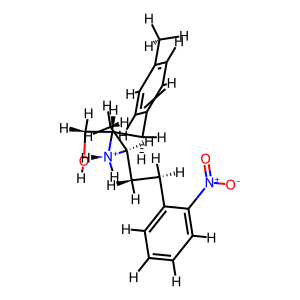

Key, sdf: ZINC000191583186


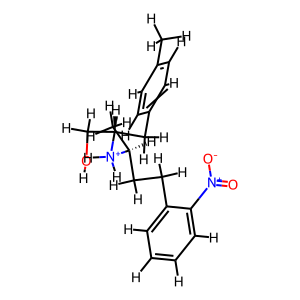

Key, mol2: ZINC000159533726


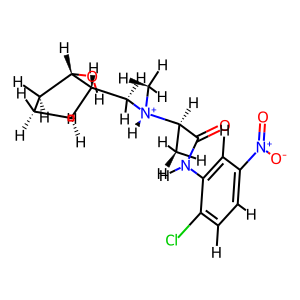

Key, sdf: ZINC000159533726


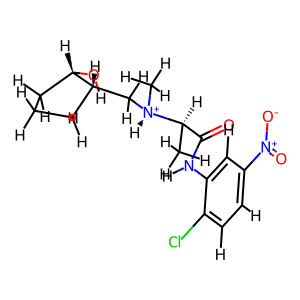

Key, mol2: ZINC000151228439


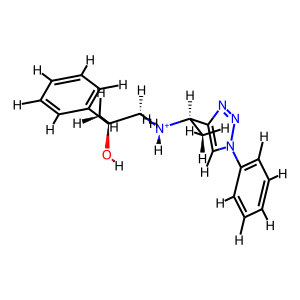

Key, sdf: ZINC000151228439


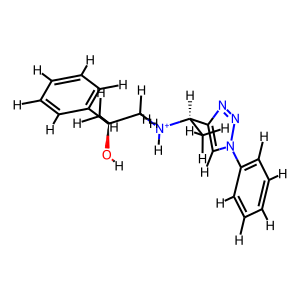

In [14]:
# Since the molecule names (the keys of the dict) are identical, we can visualizate both sets of molecules in 3D to visually compare them in 3D. This is a qualitative check of how rdkit is "seeing" the molecules.

# Get the keys from one of the dictionaries
keys = list(mol2_mols.keys())

# Iterate over the keys
for key in keys:
    # Get the molecule from each dictionary
    mol_mol2 = mol2_mols[key]
    mol_sdf = sdf_mols[key]

    # Draw the mol2 molecule with atom indices
    img_mol2 = Draw.MolToImage(mol_mol2, size=(300, 300))

    # Display the key and the image
    print(f"Key, mol2: {key}")
    display(img_mol2)

    # Draw the sdf molecule with atom indices
    img_sdf = Draw.MolToImage(mol_sdf, size=(300, 300))

    # Display the key and the image
    print(f"Key, sdf: {key}")
    display(img_sdf)

Key, mol2_H: ZINC000191583186


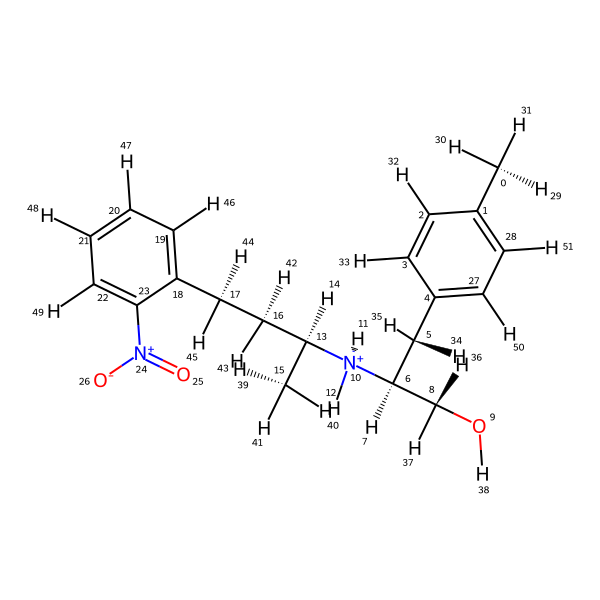

Key, sdf_H: ZINC000191583186


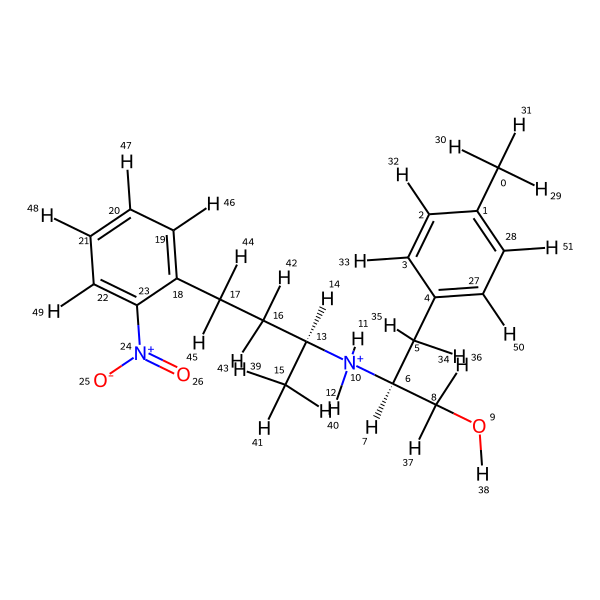

Key, mol2_H: ZINC000159533726


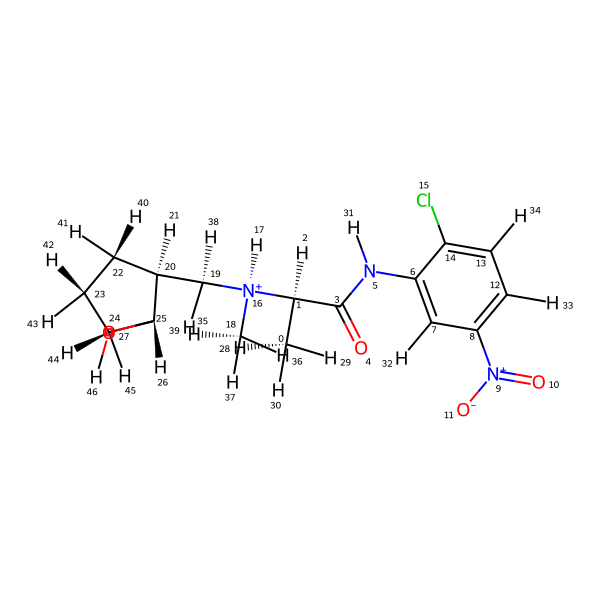

Key, sdf_H: ZINC000159533726


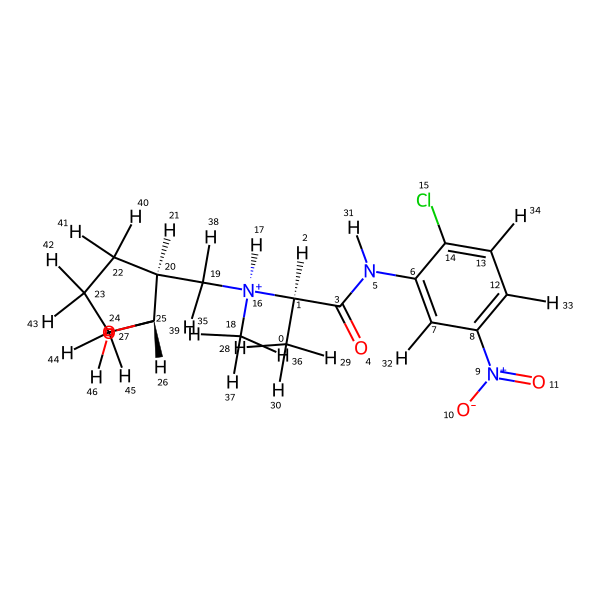

Key, mol2_H: ZINC000151228439


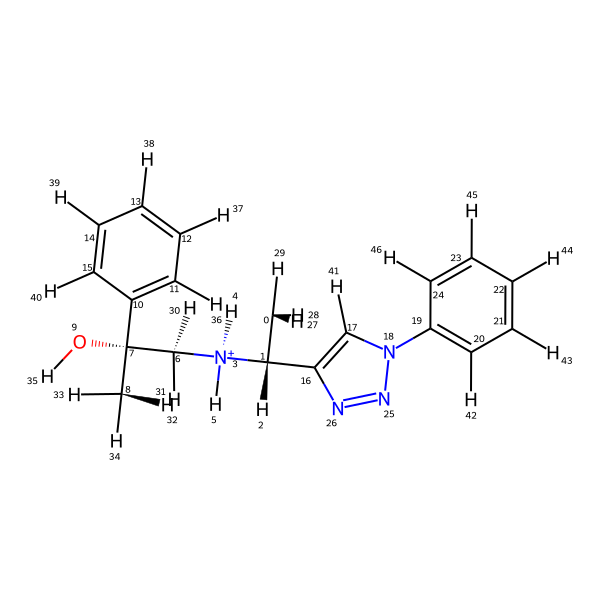

Key, sdf_H: ZINC000151228439


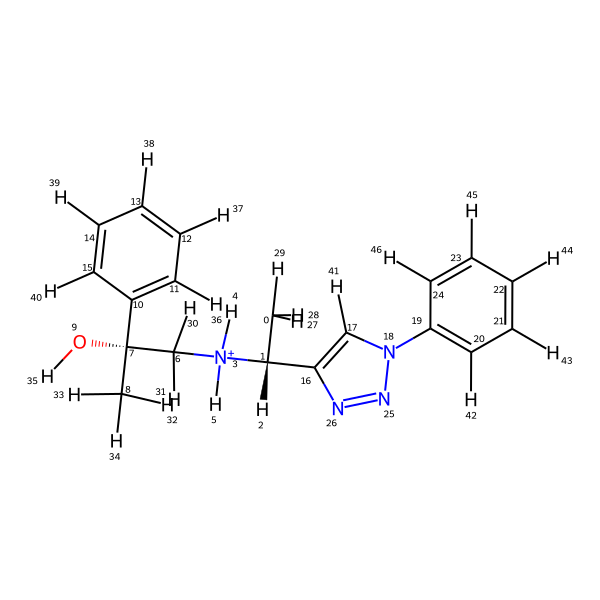

In [17]:
IPythonConsole.molSize = 600, 600
IPythonConsole.drawOptions.addAtomIndices = True

# Get the keys from one of the dictionaries
keys = list(mol2_mols.keys())

# Iterate over the keys
for key in keys:
    # Get the molecule from each dictionary
    mol_mol2_2D = mol2_mols[key]
    mol_sdf_2D = sdf_mols[key]

    # Compute 2D coordinates for the mol2 molecule
    AllChem.Compute2DCoords(mol_mol2_2D)

    # Display the key and the mol2 molecule
    print(f"Key, mol2_2D: {key}")
    display(mol_mol2_2D)

    # Compute 2D coordinates for the sdf molecule
    AllChem.Compute2DCoords(mol_sdf_2D)

    # Display the key and the sdf molecule
    print(f"Key, sdf_2D: {key}")
    display(mol_sdf_2D)

At this point, the only difference I can notice is some strange chirality settings coming from the default Mol2 supplier function the author used. However, the chirality os somewhat non-sensical because it ascribes putative stereocenters two molecules that share two identical substitutents (e.g. not chiral). Maybe something weird here is causing the mismatch, but I haven't found a way to make my sdf supplier function work like that. 

What I can see however, is that the molecules appear to have a relatively identical 3D shape and identical atom indicies. Rigorously setting equivalent 3D positions seems tricky (as opposed to relative), but I think I have other evidence later that this doesn't matter. Translation/rotation does not affect angles between atoms/bonds in a intramolecular fashion, only intermolecular - which does not matter in torsion. 

However, I was worried that the graphical atom indices used here aren't actually real. Based on rdkit, documentation, we can check the true atomic indicies like so: 

In [30]:
# Prevent truncating of dataframe display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Load the molecules with the custom SDF function
names_custom, mols_custom = custom_sdmolsupplier_H("output.sdf")

# Load the molecules with Mol2MolSupplier
names_mol2, mols_mol2 = Mol2MolSupplier("example.mol2")


# Define a method to compare the atom indicies of two molecules so we can loop over our three molecules. If the molecules match, we return True and the atom data as dataframes. If the molecules do not match, we return False and None for the dataframes.
def compare_molecules(mol1, mol2):
    atoms1 = [(atom.GetIdx(), atom.GetSymbol()) for atom in mol1.GetAtoms()]
    atoms2 = [(atom.GetIdx(), atom.GetSymbol()) for atom in mol2.GetAtoms()]

    if atoms1 != atoms2:
        print(f"Discrepancy found: {atoms1} vs {atoms2}")
        return False, None, None

    # Convert the atom data to dataframes
    df1 = pd.DataFrame(atoms1, columns=["AtomIdx", "Symbol"])
    df2 = pd.DataFrame(atoms2, columns=["AtomIdx", "Symbol"])

    return True, df1, df2


# Iterate over all molecules
for name in names_custom:
    mol_custom = mols_custom[name]
    mol_mol2 = mols_mol2[name]

    print(f"Molecule: {name}")
    match, df_custom, df_mol2 = compare_molecules(mol_custom, mol_mol2)
    if not match:
        print("Molecules do not match!")
    else:
        print("Molecules match!")
        print("Custom molecule atom data:")
        display(df_custom.T)
        print("Mol2 molecule atom data:")
        display(df_mol2.T)

Molecule: ZINC000191583186
Molecules match!
Custom molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Symbol,C,C,C,C,C,C,C,H,C,O,N,H,H,C,H,C,C,C,C,C,C,C,C,C,N,O,O,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


Mol2 molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
Symbol,C,C,C,C,C,C,C,H,C,O,N,H,H,C,H,C,C,C,C,C,C,C,C,C,N,O,O,C,C,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


Molecule: ZINC000159533726
Molecules match!
Custom molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Symbol,C,C,H,C,O,N,C,C,C,N,O,O,C,C,C,Cl,N,H,C,C,C,H,C,C,C,C,H,O,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


Mol2 molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Symbol,C,C,H,C,O,N,C,C,C,N,O,O,C,C,C,Cl,N,H,C,C,C,H,C,C,C,C,H,O,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


Molecule: ZINC000151228439
Molecules match!
Custom molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Symbol,C,C,H,N,H,H,C,C,C,O,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,N,N,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


Mol2 molecule atom data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
AtomIdx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Symbol,C,C,H,N,H,H,C,C,C,O,C,C,C,C,C,C,C,C,N,C,C,C,C,C,C,N,N,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H


However, despite what appears like 2D and 3D equivalence (except for the weird chirality thing), I can show you that the results are unfortunately different: 

In [28]:
%run refactor_Torsion_Strain.py -i example.mol2 -o mol2.csv 
#NOTE: I do not allow the user to overwrite file names, this won't run unless you change "mol2.csv"
#I use mol2.csv in the analysis so if you want to test my code, just pick a different name 

3 molecules finished reading. Calculating strain energy...
3 successful / 0 NA. Please check: mol2.csv


In [29]:
%run refactor_Torsion_Strain.py -i output.sdf -o sdf.csv 
#NOTE: I do not allow the user to overwrite file names, this won't run unless you change "sdf.csv"
#I use sdf.csv in the analysis so if you want to test my code, just pick a different name

3 molecules finished reading. Calculating strain energy...
3 successful / 0 NA. Please check: sdf.csv


In [39]:


def create_dataframes(file1, file2):
    # Define a regular expression for the separator
    sep = r',(?![^[]*\])'  # Pass the compiled regular expression pattern as a string

    # Determine the origin from the filename
    origin1 = 'sdf' if 'sdf' in file1 else 'mol2'
    origin2 = 'sdf' if 'sdf' in file2 else 'mol2'

    dataframes = []

    with open(file1, "r") as f1, open(file2, "r") as f2:
        reader1 = csv.reader(f1)
        reader2 = csv.reader(f2)

        for line1, line2 in zip(reader1, reader2):
            # Define general column names
            column_names = ["Molecule_ID", "Total_Energy", "Energy_Lower_Bound", "Energy_Upper_Bound", "Num_Torsion_Patterns"]

            # Calculate the number of torsion patterns
            num_torsion_patterns = (len(line1) - len(column_names)) // 10

            # Generate column names for each torsion pattern
            for i in range(1, num_torsion_patterns + 1):
                column_names.extend([
                    f"Torsion_{i}_Energy", f"Torsion_{i}_Energy_Lower_Bound", 
                    f"Torsion_{i}_Energy_Upper_Bound", f"Torsion_{i}_Atom_Indices", 
                    f"Torsion_{i}_Dihedral_Angle", f"Torsion_{i}_SMARTS_Pattern", 
                    f"Torsion_{i}_Hierarchy_Class", f"Torsion_{i}_Method", 
                    f"Torsion_{i}_Indices_Reversed", f"Torsion_{i}_Rule_Index"
                ])

            # Slice the lines based on the number of torsion patterns
            line1 = line1[:len(column_names)]
            line2 = line2[:len(column_names)]

            # Convert lines to DataFrames
            df1 = pd.DataFrame([line1], columns=column_names)
            df2 = pd.DataFrame([line2], columns=column_names)

            # Add the origin to the DataFrames
            df1.insert(0, 'Origin', origin1)
            df2.insert(0, 'Origin', origin2)

            # Concatenate the new DataFrame with df and drop the index
            df = pd.concat([df1, df2], ignore_index=True)

            dataframes.append(df)

            # Reset column names for next line
            column_names = column_names[:5]

    return dataframes

In [41]:
df_1, df_2, df_3 = create_dataframes("sdf.csv", "mol2.csv")
display(df_1)
display(df_2)
display(df_3)   

,Origin,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern,Torsion_7_Hierarchy_Class,Torsion_7_Method,Torsion_7_Indices_Reversed,Torsion_7_Rule_Index,Torsion_8_Energy,Torsion_8_Energy_Lower_Bound,Torsion_8_Energy_Upper_Bound,Torsion_8_Atom_Indices,Torsion_8_Dihedral_Angle,Torsion_8_SMARTS_Pattern,Torsion_8_Hierarchy_Class,Torsion_8_Method,Torsion_8_Indices_Reversed,Torsion_8_Rule_Index
0,sdf,ZINC000191583186,5.605219996833657,5.056429357277703,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[15, 13, 16, 17]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[8, 6, 10, 13]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.34522247008497436,0.33908125045590787,0.3514242249136928,"[5, 6, 8, 9]",60.00831008335173,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[18, 23, 24, 25]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,6,0.006707819673103034,-0.022299325452382023,0.037155275308878924,"[27, 4, 5, 6]",89.99270199528776,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,2
1,mol2,ZINC000191583186,5.621730380254799,5.0724614891320625,nan,4,1.5149015019717655,1.4720415536611848,1.5610762283636115,"[15, 13, 16, 17]",-79.9987689699916,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,8,1.1629499135175863,1.0138763654377367,nan,"[16, 13, 10, 6]",-159.99678602096148,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,7,1.1627673850560352,1.0137656230416119,nan,"[8, 6, 10, 13]",-159.9987199068972,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,5,1.0408019376654853,0.8903165100240227,1.2452601666364487,"[19, 18, 17, 16]",0.27343903595492747,[a:1][c:2]!@[CX4H2:3][CX4:4],specific,exact,False,3,0.34528595288770225,0.33914296320237924,0.3514895675876632,"[4, 5, 6, 8]",59.99348627709831,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,1,0.345222470

,Origin,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index,Torsion_6_Energy,Torsion_6_Energy_Lower_Bound,Torsion_6_Energy_Upper_Bound,Torsion_6_Atom_Indices,Torsion_6_Dihedral_Angle,Torsion_6_SMARTS_Pattern,Torsion_6_Hierarchy_Class,Torsion_6_Method,Torsion_6_Indices_Reversed,Torsion_6_Rule_Index
0,sdf,ZINC000159533726,3.440838280823955,2.4289098751947322,nan,4,2.1206363671576907,1.2832134972295552,nan,"[16, 1, 3, 4]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[14, 6, 5, 3]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[16, 19, 20, 22]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.026408724999889943,0.013841973955324827,0.03924319628256051,"[7, 8, 9, 10]",0.005349331640332753,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988804137,-0.012464309920902417,0.035700147597479415,"[0, 1, 16, 18]",-179.99253735514415,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[20, 19, 16, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1
1,mol2,ZINC000159533726,3.4413750912962766,2.4294311373485353,nan,4,2.1206363671576907,1.2832134972295552,nan,"[16, 1, 3, 4]",-120.00615479360211,[NH1:1][CX4:2]!@[CX3:3]=[O:4],specific,exact,False,0,0.8752468812310884,0.773987448810736,0.9962523424953412,"[14, 6, 5, 3]",-150.00414282183715,"[a:1][a:2]!@[NH1:3][C,c:4]",specific,exact,False,3,0.39562014452426714,0.3888043941382421,0.40251512333759515,"[16, 19, 20, 22]",-61.38963312922269,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.02694553547221107,0.014363236109127653,0.03979653843518938,"[12, 8, 9, 11]",0.01971914685896898,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5,0.011319227988804137,-0.012464309920902417,0.035700147597479415,"[0, 1, 16, 18]",-179.99253735514415,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,6,0.01114072330755745,-0.01263239662804397,0.03550998609413992,"[20, 19, 16, 1]",179.9962690609747,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1


,Origin,Molecule_ID,Total_Energy,Energy_Lower_Bound,Energy_Upper_Bound,Num_Torsion_Patterns,Torsion_1_Energy,Torsion_1_Energy_Lower_Bound,Torsion_1_Energy_Upper_Bound,Torsion_1_Atom_Indices,Torsion_1_Dihedral_Angle,Torsion_1_SMARTS_Pattern,Torsion_1_Hierarchy_Class,Torsion_1_Method,Torsion_1_Indices_Reversed,Torsion_1_Rule_Index,Torsion_2_Energy,Torsion_2_Energy_Lower_Bound,Torsion_2_Energy_Upper_Bound,Torsion_2_Atom_Indices,Torsion_2_Dihedral_Angle,Torsion_2_SMARTS_Pattern,Torsion_2_Hierarchy_Class,Torsion_2_Method,Torsion_2_Indices_Reversed,Torsion_2_Rule_Index,Torsion_3_Energy,Torsion_3_Energy_Lower_Bound,Torsion_3_Energy_Upper_Bound,Torsion_3_Atom_Indices,Torsion_3_Dihedral_Angle,Torsion_3_SMARTS_Pattern,Torsion_3_Hierarchy_Class,Torsion_3_Method,Torsion_3_Indices_Reversed,Torsion_3_Rule_Index,Torsion_4_Energy,Torsion_4_Energy_Lower_Bound,Torsion_4_Energy_Upper_Bound,Torsion_4_Atom_Indices,Torsion_4_Dihedral_Angle,Torsion_4_SMARTS_Pattern,Torsion_4_Hierarchy_Class,Torsion_4_Method,Torsion_4_Indices_Reversed,Torsion_4_Rule_Index,Torsion_5_Energy,Torsion_5_Energy_Lower_Bound,Torsion_5_Energy_Upper_Bound,Torsion_5_Atom_Indices,Torsion_5_Dihedral_Angle,Torsion_5_SMARTS_Pattern,Torsion_5_Hierarchy_Class,Torsion_5_Method,Torsion_5_Indices_Reversed,Torsion_5_Rule_Index
0,sdf,ZINC000151228439,2.6254850156147613,2.1481317994215723,3.2248541322315853,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[16, 1, 3, 6]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,1,0.7072729781090777,0.5657264515554503,0.8932015389124958,"[11, 10, 7, 9]",-120.00211031322509,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,0,0.3450126608448396,0.338874330049487,0.3512114446836594,"[3, 6, 7, 8]",60.001998575596204,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,2,0.19399550580280375,0.133121574139351,0.26107092644386387,"[26, 16, 1, 3]",-120.31533631847783,"[a:1][c:2]!@[CX4H1:3][N,O:4]",specific,exact,False,3,0.1420856999880718,0.06072392664085746,0.23533248458078143,"[20, 19, 18, 25]",0.2932336556874904,[*:1]~[cX3:2]!@[n:3]~[*:4],general,exact,False,5
1,mol2,ZINC000151228439,3.1921530742055166,2.7767434999098652,3.720129943770846,4,1.2261404216241005,1.0624704033253995,1.4487026903383522,"[16, 1, 3, 6]",160.0003287996878,[*:1]~[CX4:2]!@[NX4:3]~[*:4],general,exact,False,2,0.8655860990765392,0.7981722814216906,0.9413503909302561,"[3, 1, 16, 26]",-120.31533631847783,[!#1:1][CX4:2]!@[CX3H0:3][!#1:4],specific,exact,False,3,0.7072729781090777,0.5657264515554503,0.8932015389124958,"[11, 10, 7, 9]",-120.00211031322509,"[a:1][c:2]!@[CX4H0:3][N,O:4]",specific,exact,False,1,0.3450126608448396,0.338874330049487,0.3512114446836594,"[3, 6, 7, 8]",60.001998575596204,[!#1:1][CX4:2]!@[CX4:3][!#1:4],specific,exact,False,0,0.03716316530509145,0.024284919846811026,0.05032883163365015,"[20, 19, 18, 25]",0.2932336556874904,[a:1][a:2]!@[NX3:3][!#1:4],specific,exact,False,5


Just a side note, because of how the output data is structured, it gets really awkward and difficult to debug what is going on. Every line of the csv has a different amount of elements based on the torsions. I don't know what data structure should have been used, but this feels very unideal. 

However, the take away right now is the difference in total strain energy found. In these examples (which are very limited), our calculations are *very* close. Particularly for the first two. The last molecule is like .5 units off. I don't know how to estimate how much that matters, but I haven't really tried. I've just been focused on fixing them because the calculation is deterministic. Given the same input, we should get the same output. 

So now let's look at what is actually different between our outputs. I had some issues with sig figs in an earlier version of this, so I rounded to 8 places here. This function will select the unique columns.

In [45]:
def select_unique_columns_rounded(df):
    # Reset the index of df
    df = df.reset_index(drop=True)

    # Round the DataFrame to the 8th decimal place
    df_rounded = df.round(8)

    # Select the first two columns of df_rounded
    first_two_columns = df_rounded.iloc[:, :2]

    # Select the rest of the columns where the rows have different values
    unique_columns = df_rounded.iloc[:, 2:].loc[:, df_rounded.iloc[:, 2:].nunique() > 1]

    # Concatenate the first two columns and the unique columns
    df_unique = pd.concat([first_two_columns, unique_columns], axis=1)

    # Return the new DataFrame
    return df_unique

In [48]:
df_1_r8_unique = select_unique_columns_rounded(df_1)
df_2_r8_unique = select_unique_columns_rounded(df_2)
df_3_r8_unique = select_unique_columns_rounded(df_3)
print("Here are the shapes of the differences in the dataframes:")
print(df_1_r8_unique.shape, df_2_r8_unique.shape, df_3_r8_unique.shape)

Here are the shapes of the differences in the dataframes:
(2, 9) (2, 9) (2, 32)


In [49]:
display(df_1_r8_unique)

,Origin,Molecule_ID,Total_Energy,Energy_Lower_Bound,Torsion_7_Energy,Torsion_7_Energy_Lower_Bound,Torsion_7_Energy_Upper_Bound,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle
0,sdf,ZINC000191583186,5.605219996833657,5.056429357277703,0.02635434808368613,0.013789212541832876,0.03918709847466442,"[18, 23, 24, 25]",-0.0040091720895600565
1,mol2,ZINC000191583186,5.621730380254799,5.0724614891320625,0.04286473150482756,0.029821344396192107,0.056205983956472805,"[22, 23, 24, 26]",0.44585819818713934


In [62]:
print("The difference in energy is caused by different Torsion Indices and their Dihedral Angles.")
display(df_1_r8_unique[['Origin','Torsion_7_Atom_Indices', 'Torsion_7_Dihedral_Angle']])


The difference in energy is caused by different Torsion Indices and their Dihedral Angles.


,Origin,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle
0,sdf,"[18, 23, 24, 25]",-0.0040091720895600565
1,mol2,"[22, 23, 24, 26]",0.44585819818713934


In [59]:
print("We can find the SMARTs pattern associated with this in df_1:")
display(df_1[['Origin', 'Torsion_7_Atom_Indices', 'Torsion_7_Dihedral_Angle', 'Torsion_7_SMARTS_Pattern']])
print("Bafflingly, the SMARTs is the same!")
print("We can try to visualize this, let's start with the mol2 file. However the results won't make sense.")




We can find the SMARTs pattern associated with this in df_1:


,Origin,Torsion_7_Atom_Indices,Torsion_7_Dihedral_Angle,Torsion_7_SMARTS_Pattern
0,sdf,"[18, 23, 24, 25]",-0.0040091720895600565,[a:1][a:2]!@[NX3:3][!#1:4]
1,mol2,"[22, 23, 24, 26]",0.44585819818713934,[a:1][a:2]!@[NX3:3][!#1:4]


Bafflingly, the SMARTs is the same!
We can try to visualize this, let's start with the mol2 file. However the results won't make sense.


Matching atom indices via Chem.MolFromSmarts: (18, 23, 24, 26)
Matching atom indices found from df_1: [22, 23, 24, 26], Origin: mol2
Key, MOL2: ZINC000191583186


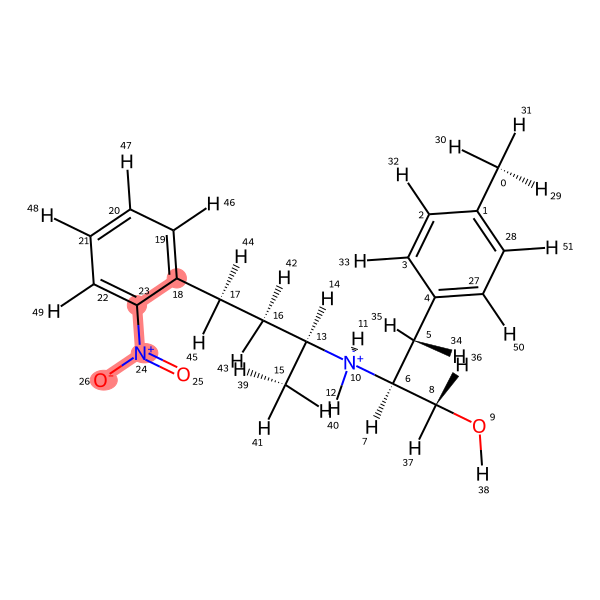

In [66]:
# Get the first molecule and its key from the mol2_mols dictionary
key_H, mol_H = list(mol2_mols.items())[0]

# Define the SMARTS pattern
smarts = "[a:1][a:2]!@[NX3:3][!#1:4]"

# Compute 2D coordinates for the molecule
AllChem.Compute2DCoords(mol_H)

# Find the atoms that match the SMARTS pattern
patt = Chem.MolFromSmarts(smarts)
match = mol_H.GetSubstructMatch(patt)

# Print the tuple of matching atom indices
print(f"Matching atom indices via Chem.MolFromSmarts: {match}")
print(f"Matching atom indices found from df_1: {df_1['Torsion_7_Atom_Indices'][1]}, Origin: {df_1['Origin'][1]}")

# Create a temporary copy of the molecule for highlighting
mol_H_temp = Chem.Mol(mol_H)

# Highlight the matching atoms on the temporary copy
mol_H_temp.GetSubstructMatch(patt)

# Display the key and the temporary molecule with the matching atoms highlighted
print(f"Key, MOL2: {key_H}")
display(mol_H_temp)

This is an understandable kind of error because that SMARTs pattern could fit either aromatic carbon and connect all the way to N-O. It could also capture either oxygen 26 or oxygen 25. 

Matching atom indices via Chem.MolFromSmarts: (18, 23, 24, 25)
Matching atom indices found from df_1: [18, 23, 24, 25], Origin: sdf
Key, SDF: ZINC000191583186


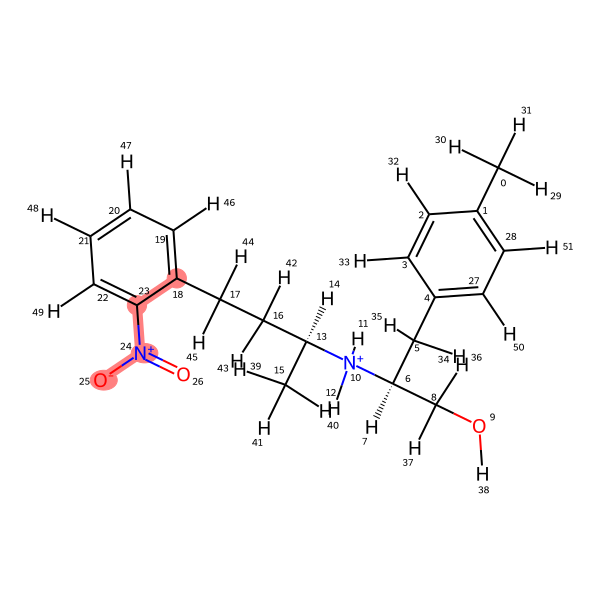

In [68]:
# Get the first molecule and its key from the sdf_mols dictionary
key_H, sdf_H = list(sdf_mols.items())[0]

# Define the SMARTS pattern
smarts = "[a:1][a:2]!@[NX3:3][!#1:4]"

# Compute 2D coordinates for the molecule
AllChem.Compute2DCoords(sdf_H)

# Find the atoms that match the SMARTS pattern
patt = Chem.MolFromSmarts(smarts)
match = sdf_H.GetSubstructMatch(patt)

# Print the tuple of matching atom indices
print(f"Matching atom indices via Chem.MolFromSmarts: {match}")
print(f"Matching atom indices found from df_1: {df_1['Torsion_7_Atom_Indices'][0]}, Origin: {df_1['Origin'][0]}")

# Create a temporary copy of the molecule for highlighting
sdf_H_temp = Chem.Mol(sdf_H)

# Highlight the matching atoms on the temporary copy
sdf_H_temp.GetSubstructMatch(patt)

# Display the key and the temporary molecule with the matching atoms highlighted
print(f"Key, SDF: {key_H}")
display(sdf_H_temp)

My code does actually agree with what rdkit finds. 

From here, I am pretty lost on how to solve this. In reality, either match is correct (actually - both matches are more correct than either of our individual matches). Both matches are going to give different dihedral angles (because they truly are different atom coordinates). However teh code is deterministic. If you re-run the csv generation on the mol2 data or on the sdf data, you will always find this exact same discrepency. 

On one hand, this is a clear limitation of his method in some respects. If his torsion data is good, it should handle both of our cases and is his code should integrate using both. 

On the other hand, even if this is the correct appraoch because I haven't considered some aspect of chemistry or something, I am no closer to figuring out *why* our matches are different. 

You can extend this analysis to the other three molecules and for every single energy change there is. It's very laborious/tedious. I can do this given more time. In the meanwhile, I've tried to just debug whatever is going on his code that I thought could cause this. Here they are: 

In [69]:
# What are ALL the atom indeces and SMARTs that differ between the two files?
%run debug_TL_lookup.py

Molecule in sdf: ZINC000191583186
Molecule in mol2: ZINC000191583186
Difference found in element 0 of indeces for molecule ZINC000191583186
TL_customSDF: [18, 23, 24, 25], TL_mol2: [22, 23, 24, 26]
No differences found in smarts for molecule ZINC000191583186
Molecule in sdf: ZINC000159533726
Molecule in mol2: ZINC000159533726
Difference found in element 2 of indeces for molecule ZINC000159533726
TL_customSDF: [7, 8, 9, 10], TL_mol2: [12, 8, 9, 11]
No differences found in smarts for molecule ZINC000159533726
Molecule in sdf: ZINC000151228439
Molecule in mol2: ZINC000151228439
Difference found in element 0 of indeces for molecule ZINC000151228439
TL_customSDF: [3, 6, 7, 8], TL_mol2: [20, 19, 18, 25]
Difference found in element 1 of indeces for molecule ZINC000151228439
TL_customSDF: [11, 10, 7, 9], TL_mol2: [3, 6, 7, 8]
Difference found in element 2 of indeces for molecule ZINC000151228439
TL_customSDF: [26, 16, 1, 3], TL_mol2: [3, 1, 16, 26]
Difference found in element 3 of indeces for 

In [70]:
# His code does complicated stuff to filter all the potential matches a molecule could have with a given SMARTs to just one that he uses for energy. What does the raw match data look like? 
%run debug_tp_match.py

Molecule in sdf: ZINC000191583186
Molecule in mol2: ZINC000191583186
Difference found: (18, 23, 24, 25) != (18, 23, 24, 26)
Difference found: (22, 23, 24, 25) != (22, 23, 24, 26)
Molecule in sdf: ZINC000159533726
Molecule in mol2: ZINC000159533726
Difference found: (7, 8, 9, 10) != (7, 8, 9, 11)
Difference found: (12, 8, 9, 10) != (12, 8, 9, 11)
Molecule in sdf: ZINC000151228439
Molecule in mol2: ZINC000151228439
Difference found: (9, 7, 6, 3) != (20, 19, 18, 17)
Difference found: (3, 6, 7, 8) != (20, 19, 18, 25)
Difference found: (3, 6, 7, 9) != (24, 19, 18, 17)
Difference found: (3, 6, 7, 10) != (24, 19, 18, 25)
Difference found: (11, 10, 7, 6) != (9, 7, 6, 3)
Difference found: (11, 10, 7, 8) != (3, 6, 7, 8)
Difference found: (15, 10, 7, 6) != (3, 6, 7, 9)
Difference found: (15, 10, 7, 8) != (3, 6, 7, 10)
Difference found: (11, 10, 7, 9) != (0, 1, 16, 26)
Difference found: (15, 10, 7, 9) != (3, 1, 16, 26)
Difference found: (11, 10, 7, 6) != (0, 1, 16, 26)
Difference found: (11, 10, 7